# ファイルチェック

In [1]:
import zipfile,os
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>")) 

In [2]:
with zipfile.ZipFile('./data.zip') as existing_zip:
    existing_zip.extractall('./')

In [3]:
print(os.listdir("./data/"))

['train_x', 'test_y', 'test_x', 'train_y']


# データ確認

In [4]:
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image

In [5]:
# データ読み込み
train_img_list = np.array(sorted(glob("./data/train_x/*.png")))
test_img_list = np.array(sorted(glob("./data/test_x/*.png")))
train_y = pd.read_csv("./data/train_y/train_y.csv")
train_y = np.array(train_y["train_y"])
test_y = pd.read_csv("./data/test_y/test_y.csv")
test_y = np.array(test_y["test_y"])

5 0 4 1 9 2 1 3 1 4


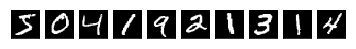

In [6]:
# trainデータ確認
num=10
np.random.RandomState(1234)
train_x_check = np.random.choice(train_img_list,num,replace=False)
test_x_check = np.random.choice(test_img_list,num,replace=False)

train_y_list = []
fig = plt.figure()
for i in range(num):
    file = train_img_list[i]
    file_idx = int(file.split("/")[-1].replace(".png",""))
    train_y_list.append(train_y[file_idx])
    subplt = fig.add_subplot(1,num,i+1)
    subplt.imshow(Image.open(file),"gray")
    subplt.tick_params(labelbottom=False,labelleft=False,labelright=False,labeltop=False)
    subplt.tick_params(bottom=False,left=False,right=False,top=False)
print(*train_y_list)

7 2 1 0 4 1 4 9 5 9


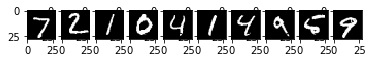

In [7]:
# テストデータ確認
test_y_list = []
fig = plt.figure()
for i in range(num):
    file = test_img_list[i]
    file_idx = int(file.split("/")[-1].replace(".png",""))
    test_y_list.append(test_y[file_idx])
    subplt = fig.add_subplot(1,num,i+1)
    subplt.imshow(Image.open(file),"gray")
print(*test_y_list)

In [8]:
# データがOKなら削除する
import shutil
shutil.rmtree("./data/")

# Sagemakerのトレーニングジョブを動かす

In [9]:
# Sagemakerインスタンス初期化と学習データのS3アップロード
import sagemaker
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker_session.default_bucket()

# ファイルをS3にアップロード
# 引数のpathにはディレクトリも指定でき、指定ディレクトリ以下すべてをアップロードしてくれる
# ファイル数が多い場合には時間がかかるため、zipで固めたほうが速い
input_data = sagemaker_session.upload_data(path='./data.zip', bucket=bucket_name, key_prefix='dataset/sagemaker_keras_mnist_handson')
print('Training data is uploaded to: {}'.format(input_data))

Training data is uploaded to: s3://sagemaker-ap-northeast-1-155580384669/dataset/sagemaker_keras_mnist_handson/data.zip


In [10]:
from sagemaker.tensorflow import TensorFlow
from sagemaker import get_execution_role

role = get_execution_role()
estimator = TensorFlow(
    source_dir="./",
    entry_point = "main.py",
    role=role,
    train_instance_count=1,
    train_instance_type="ml.p3.2xlarge",
    framework_version="1.12.0",
    py_version='py3',
    script_mode=True,
    hyperparameters={'train-batch-size': 64,
                     'test-batch-size':1024,
                     'epochs': 2})

estimator.fit(input_data)

2020-04-03 15:35:46 Starting - Starting the training job...
2020-04-03 15:35:48 Starting - Launching requested ML instances.........
2020-04-03 15:37:24 Starting - Preparing the instances for training......
2020-04-03 15:38:34 Downloading - Downloading input data...
2020-04-03 15:39:14 Training - Training image download completed. Training in progress..2020-04-03 15:39:17,172 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-04-03 15:39:18,085 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "test-batch-size": 1024,
        "model_dir": "s3://sagemaker-ap-northeast-1-155580384669/sagemaker-tensorflow-scriptmode-2020-04-03-15-3

data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
data shuffle exec...
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
2020-04-03 15:40:35,322 sagemaker-containers INFO     Reporting training SUCCESS

2020-04-03 15:40:42 Uploading - Uploading generated training model
2020-04-03 15:40:42 Completed - Training job completed
Training seconds: 128
Billable seconds: 128


In [11]:
predictor = estimator.deploy(instance_type='ml.m5.xlarge', initial_instance_count=1)

-------------!

In [12]:
predictor.delete_endpoint()